In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib

In [1]:
import utils
from utils import TrainingPlot, TimeSummary, plot_training_summary
from NNKeras import NNKeras
from sklearn.model_selection import train_test_split
import inspect

Using TensorFlow backend.


## Data Preparation

### Data Cleanup
-  Merge 64 size vectors by ignoring line breaks
-  Create subset of data by selecting non consecutive vectors

#### Cleaned data
L42023,0.04347826,0.04347826,0.,0.04347826,0.01086957,0.02173913,0.,0.02173913,0.,0.,0.,0.,0.,0.02173913,0.02173913,0.04347826,0.07608696,0.02173913,0.,0.0326087,0.01086957,0.,0.,0.0326087,0.,0.01086957,0.,0.0326087,0.,0.,0.,0.0326087,0.05434783,0.,0.01086957,0.02173913,0.04347826,0.,0.01086957,0.02173913,0.02173913,0.,0.,0.01086957,0.0326087,0.,0.04347826,0.0326087,0.01086957,0.01086957,0.,0.02173913,0.04347826,0.01086957,0.,0.01086957,0.,0.,0.,0.,0.04347826,0.02173913,0.,0.

## Network 1
### Create input dataset X and y where X has all vectors and y is one-hot vector

In [2]:
nn = NNKeras("/tf/dataset/dataset.csv")
X, y, unique_classes = nn.read_data()

In [3]:
print(X.shape)
print(y.shape)
print(X[:3])
print(y[:3])
unique_classes

(3131, 64)
(3131, 31)
         1         2         3         4         5         6         7   \
0  0.045455  0.045455  0.000000  0.000000  0.045455  0.318182  0.000000   
1  0.080000  0.060000  0.000000  0.100000  0.000000  0.000000  0.020000   
2  0.010482  0.020964  0.002096  0.012579  0.004193  0.031447  0.006289   

         8    9         10  ...        55        56        57        58  \
0  0.000000  0.0  0.045455  ...  0.000000  0.000000  0.045455  0.000000   
1  0.000000  0.0  0.000000  ...  0.000000  0.020000  0.020000  0.040000   
2  0.006289  0.0  0.014675  ...  0.010482  0.006289  0.000000  0.010482   

        59        60        61        62        63        64  
0  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.00000  0.000000  0.020000  0.000000  0.000000  0.000000  
2  0.02935  0.008386  0.010482  0.020964  0.012579  0.054507  

[3 rows x 64 columns]
[[ True False False False False False False False False False False False
  False False False False F

### Randomly select train, test datasets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train[:3])
print(y_train[:3])

            1         2         3         4         5         6         7   \
2113  0.000000  0.013333  0.005333  0.000000  0.000000  0.026667  0.013333   
3029  0.075269  0.043011  0.043011  0.021505  0.000000  0.010753  0.000000   
2130  0.056338  0.004695  0.000000  0.046948  0.014085  0.000000  0.004695   

            8         9         10  ...        55        56        57     58  \
2113  0.000000  0.000000  0.008000  ...  0.018667  0.002667  0.002667  0.008   
3029  0.000000  0.021505  0.000000  ...  0.010753  0.000000  0.000000  0.000   
2130  0.023474  0.009390  0.004695  ...  0.004695  0.014085  0.000000  0.000   

            59       60        61        62        63        64  
2113  0.016000  0.00000  0.000000  0.029333  0.002667  0.000000  
3029  0.010753  0.00000  0.021505  0.010753  0.010753  0.010753  
2130  0.009390  0.00939  0.042254  0.004695  0.037559  0.028169  

[3 rows x 64 columns]
[[False False False False False False False False False False False False
  Fal

In [5]:
inspect.getsourcelines(nn.train)

(['    def train(self, X, y, node_range, show_summary: bool = False):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=5)\n',
  '        for num_nodes in node_range:\n',
  '            nodes = [64, num_nodes]\n',
  '            model = self.base_model(nodes)\n',
  '            summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  '            if show_summary:\n',
  '                model.summary()\n',
  "            print('Test loss:', score[0])\n",
  "            print('Test accuracy:', score[1])\n"],
 53)

In [7]:
nn.train(X, y, range(1, 2), True)

32/32 [==============================] - 0s 2ms/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
dense_4 (Dense)              (None, 31)                62        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.15585796535015106
Test accuracy: 0.9677419066429138


## Network 2
### Use the training method for nodes 5 - 32

In [8]:
nn.train(X, y, range(5, 32))

32/32 [==============================] - 0s 2ms/step
Test loss: 0.1429307907819748
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 3ms/step
Test loss: 0.14281298220157623
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 4ms/step
Test loss: 0.14325407147407532
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 7ms/step
Test loss: 0.1425652951002121
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 5ms/step
Test loss: 0.14129656553268433
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 5ms/step
Test loss: 0.1418779492378235
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 12ms/step
Test loss: 0.1425275206565857
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 11ms/step
Test loss: 0.1427726298570633
Test accuracy: 0.9677419066429138
32/32 [==============================] - 0s 8ms/step
Test l

### Network 2 reaches accuracy of 96% with just 2 nodes. We will take P=6

## Network 3
### Optimal number of hidden layers with P/2 neurons

In [9]:
inspect.getsourcelines(nn.train_network_3)

(['    def train_network_3(self, X, y):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)\n',
  '        P = 6\n',
  '        for num_layers in range(1, 10):\n',
  '            nodes = [64] + [int(P / 2)] * num_layers\n',
  '            model = self.base_model(nodes)\n',
  '            summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  "            print('Test loss:', score[0])\n",
  "            print('Test accuracy:', score[1])\n"],
 83)

In [10]:
nn.train_network_3(X, y)

157/157 [==============================] - 1s 5ms/step
Test loss: 0.16075359085562882
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Test loss: 0.14322554970243176
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Test loss: 0.14281515644234458
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Test loss: 0.1427883968991079
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Test loss: 0.14293263776666798
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 6ms/step
Test loss: 0.390590252390333
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 6ms/step
Test loss: 0.39060161106146063
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 6ms/step
Test loss: 0.14275720819925805
Test accuracy: 0.9677418956331386
157/157 [==============================] - 

### We are getting accuracy with only 2 layers. We will take hidden layers = 2

## Network 4

In [11]:
inspect.getsourcelines(nn.train_network_4)

(['    def train_network_4(self, X, y):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)\n',
  '        for P in range(2, 12):\n',
  '            for num_layers in range(1, 5):\n',
  '                nodes = [64] + [int(P / 2)] * num_layers\n',
  '                model = self.base_model(nodes)\n',
  '                summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '                score = model.evaluate(X_test, y_test)\n',
  "                print('Test loss:', score[0])\n",
  "                print('Test accuracy:', score[1])\n",
  "                print('Nodes:', P)\n"],
 94)

In [12]:
nn.train_network_4(X, y)

157/157 [==============================] - 2s 11ms/step
Test loss: 0.1598698948598971
Test accuracy: 0.9677418956331386
Nodes: 2
157/157 [==============================] - 1s 8ms/step
Test loss: 0.39059814108405144
Test accuracy: 0.9677418956331386
Nodes: 2
157/157 [==============================] - 1s 8ms/step
Test loss: 0.14374571450197013
Test accuracy: 0.9677418956331386
Nodes: 2
157/157 [==============================] - 2s 10ms/step
Test loss: 0.3905639768026437
Test accuracy: 0.9677418956331386
Nodes: 2
157/157 [==============================] - 2s 13ms/step
Test loss: 0.1599990817581772
Test accuracy: 0.9677418956331386
Nodes: 3
157/157 [==============================] - 2s 12ms/step
Test loss: 0.18908511311005635
Test accuracy: 0.9677418956331386
Nodes: 3
157/157 [==============================] - 2s 11ms/step
Test loss: 0.1435745235081691
Test accuracy: 0.9677418956331386
Nodes: 3
157/157 [==============================] - 2s 14ms/step
Test loss: 0.3905894463988626
Test accur

## Network 5
### We will use same training function with each column of y as 1D matrix
### Take average of each inidividual prediction

In [14]:
inspect.getsourcelines(nn.train_network_4)

(['    def train_network_4(self, X, y):\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)\n',
  '        for P in range(2, 12):\n',
  '            for num_layers in range(1, 5):\n',
  '                nodes = [64] + [int(P / 2)] * num_layers\n',
  '                model = self.base_model(nodes)\n',
  '                summary = model.fit(X_train, y_train, epochs=10, verbose=0)\n',
  '                score = model.evaluate(X_test, y_test)\n',
  "                print('Test loss:', score[0])\n",
  "                print('Test accuracy:', score[1])\n",
  "                print('Nodes:', P)\n"],
 94)

In [15]:
avg_score = nn.single_output_score(X, y)
avg_score

157/157 [==============================] - 6s 37ms/step
Test loss: 0.07583794576726902
Test accuracy: 0.9872611430799885
157/157 [==============================] - 4s 25ms/step
Test loss: 0.17010452925779257
Test accuracy: 0.961783436073619
157/157 [==============================] - 3s 21ms/step
Test loss: 0.13488652044610613
Test accuracy: 0.9681528662420382
157/157 [==============================] - 3s 21ms/step
Test loss: 0.13914919108342214
Test accuracy: 0.9745222971697521
157/157 [==============================] - 3s 22ms/step
Test loss: 0.09924551692737896
Test accuracy: 0.9808917163283961
157/157 [==============================] - 4s 26ms/step
Test loss: 0.2000415163814642
Test accuracy: 0.9490445833297292
157/157 [==============================] - 4s 22ms/step
Test loss: 0.1971288748607514
Test accuracy: 0.9490445901633827
157/157 [==============================] - 4s 26ms/step
Test loss: 0.11046221425199206
Test accuracy: 0.9745222895768038
157/157 [==========================

0.9373330589998471

# Validation
### In this dataset, our neural network reaches accuracy of 96% with sample data and 98% with full dataset. Hence it is necessary to validate the accuracy of data with trained model.
### Keras allows callbacks for training visualization. Function below runs for 200 epochs with 32 neurons and saves the model

In [17]:
inspect.getsourcelines(nn.train_with_callback)

(['    def train_with_callback(self, X, y, model_file: str = None):\n',
  '        if model_file is None:\n',
  '            model_file = self._model\n',
  '        plot_losses = TrainingPlot()\n',
  '        time_summary = TimeSummary()\n',
  '        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=5)\n',
  '        for num_nodes in range(31, 32):\n',
  '            nodes = [64, num_nodes]\n',
  '            model = self.base_model(nodes)\n',
  '            callbacks = [self._call_back, time_summary, plot_losses, self._call_back_model]\n',
  '            summary = model.fit(X_train, y_train, epochs=200, verbose=0, callbacks=callbacks)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  '            plot_training_summary(summary, time_summary)\n',
  '            score = model.evaluate(X_test, y_test)\n',
  '            model.save(model_file)\n',
  "            print('Test loss:', score[0])\n",
  "            print('Test accuracy:', sco

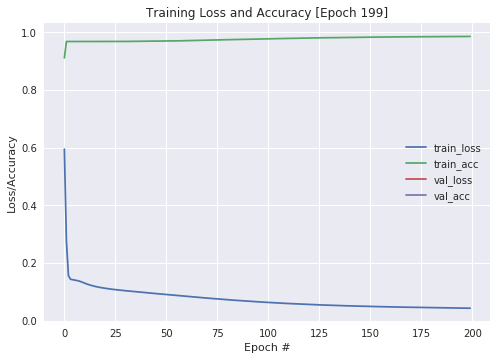

32/32 [==============================] - 5s 154ms/step
Training time: 0:06:46.855954
Epoch time avg: 0:00:00.801387


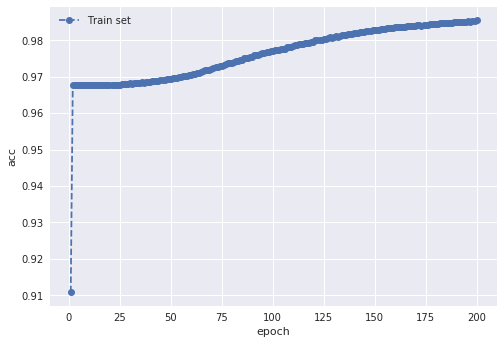

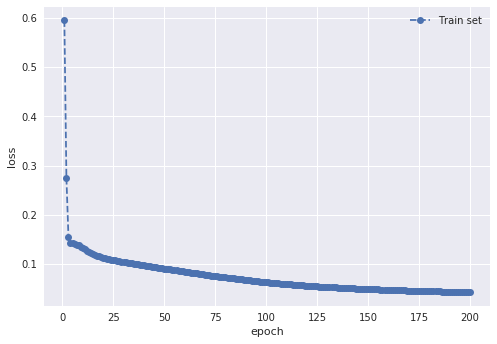

32/32 [==============================] - 0s 160us/step
Test loss: 0.052675314247608185
Test accuracy: 0.9768145084381104


In [18]:
nn.train_with_callback(X, y, '/tf/models/model.h5')

### Predict from souce data

In [19]:
inspect.getsourcelines(nn.predict)

(['    def predict(self, file_path: str, classes: [], num_lines: int = 30, model_file: str = None):\n',
  '        if model_file is None:\n',
  '            model_file = self._model\n',
  '        model = load_model(model_file)\n',
  '        with open(file_path, "r") as fp:\n',
  '            for i, line in enumerate(fp):\n',
  '                predict_vector = np.array(line.split(",")).astype(float).reshape(1, 64)\n',
  '                prediction = model.predict_classes(predict_vector)\n',
  '                print(classes[0].values[prediction])\n',
  '                if i > num_lines:\n',
  '                    break\n'],
 120)

In [20]:
nn.predict("/tf/dataset/ae002161.csv", unique_classes, 5, "/tf/models/model.h5")

['AE002161']
['AE002161']
['AE002161']
['AE002161']
['AE005672']
['AE002161']
['AE002161']


In [21]:
nn.predict("/tf/dataset/ae003852.csv", unique_classes, 5, "/tf/models/model.h5")

['BA000004']
['AE003852']
['AE009442']
['AE003852']
['AE003853']
['AE003852']
['AE014075']


---

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X.shape)
print(y.shape)

tmp = DecisionTreeClassifier(min_samples_leaf=10)
tmp.fit(X_train, y_train)
y_pred = tmp.predict(X_test)
print('test', accuracy_score(y_pred, y_test))
y_pred_train = tmp.predict(X_train)
print('train', accuracy_score(y_pred_train, y_train))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
# print(pca.components_)
X_proj = pca.transform(X_test)

f, ax = plt.subplots(2, sharex=True)
f.set_figheight(10)
ax[0].scatter(X_proj[:, 0], X_proj[:, 1], c=np.argmax(y_test, axis=1), alpha=0.9)
ax[1].scatter(X_proj[:, 0], X_proj[:, 1], c=np.argmax(y_pred, axis=1), alpha=0.9)